# Trabalho 2 - Visualização Computacional

- Prof. Ricardo Marcondes Marcacini
- Monitor PAE: Ângelo César Mendes da Silva

##Objetivos
Análise exploratória usando técnicas de visualização computacional para dados textuais.

## Feito por
- Caio Augusto Duarte Basso
- Gabriel Garcia Lorencetti

## Vídeo
https://youtu.be/SLgEFhRiiHY

### Requisitos do trabalho
1. A base de dados deve possuir no mínimo 1000 documentos textuais.
2. Aplique dois tipos de pré-processamento para representação dos textos, Bag-of-words (BoW) e Text Embeddings (qualquer estratégia vista em sala de aula, como word2vec).
3. Faça uma projeção bidimensional da coleção textual (justifique a estratégia
utilizada). Utilize um método de clustering para definir cores aos pontos. Se a base de dados possuir informação de classe, então pode utilizar tal informação no lugar de clustering.
4. Faça visualização usando k-NNG (justifique a medida de proximidade utilizada e a representação escolhida, isto é, BoW ou embeddings). Utilize um método de
clustering para definir cores aos vértices do grafo. Se a base de dados possuir
informação de classe, então pode utilizar tal informação no lugar de clustering.
5. Faça projeções bidimensionais de algumas palavras e palavras vizinhas (que você considera importante para o seu domínio de aplicação) por meio de word vectors (e.g. extraído do word2vec).
6. Gere uma visualização baseada em tópicos para sua base de textos e descreva três tópicos que considerou relevantes.


### Instalando e importando as bibliotecas


In [ ]:
# Instalando bibliotecas
!pip install plotly.express
!pip install bertopic
!pip install gensim

In [ ]:
# Importando bibliotecas
import pandas as pd
import string

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans

import re

from scipy.spatial.distance import cosine
import numpy as np
import networkx as nx
from plotly import graph_objs as go
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import gensim
from gensim.models import KeyedVectors

from bertopic import BERTopic

stop_words = nltk.corpus.stopwords.words('english')

### Importando a base de dados textual

Fake news (em tradução livre, notícias falsas) se tornaram um dos maiores problemas de nossa época, impactando o nosso discurso dentro e fora da internet e representando riscos reais a democracia e a estabilidade da sociedade. Um caso muito atual de disseminação de fake news é o do movimento anti-vacina, onde indivíduos contrários ao uso de vacinas espalham conteúdos falsos, alegando que suas composições químicas são prejudiciais à população. Outro exemplo -- que será mais retratado neste conjunto de dados -- foi a campanha eleitoral à presidência dos Estados Unidos, marcada por escândalos, bate-bocas, boatos e notícias falsas.  

Este conjunto de dados (disponível [neste link](https://www.kaggle.com/hassanamin/textdb3)) possui 6317 notíciais retiradas da internet (com manchete e corpo da notícia) e a informação se ela é real ou falsa (REAL ou FAKE).

In [ ]:
# faça o upload do arquivo data.csv disponibilizado em conjunto com este notebook
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [ ]:
df = pd.read_csv('data.csv')
df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6312,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6313,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6314,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6315,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


### Pré-processamento dos dados

In [ ]:
# removendo a coluna de id, que não será relevante para as análises que serão feitas
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# removendo valores faltantes e pegando as 3000 primeiras notícias, para que o processamento fique menos custoso
df = df.dropna(how='any',axis=0) 
df = df[:3000]

#### Remoção de Stopwords

In [ ]:
# função que remove pontuações, stop words e dígitos
def remove_stopwords(text,lang,domain_stopwords=[]):
  
  stop_words = nltk.corpus.stopwords.words(lang)
  
  s = str(text).lower() # minúsculo
  s = re.sub('\W+', ' ', s)
  tokens = word_tokenize(s) #obtem tokens
  v = [i for i in tokens if not i in stop_words and not i in domain_stopwords and not any(s.isdigit() for s in i)] # remove stopwords e dígitos
  s = ""
  for token in v:
    s += token+" "
  return s.strip()

#### Stemming/Radicalização de Termos

In [ ]:
# stemming
def stemming(text,lang):
  
  stemmer = PorterStemmer() # stemming para ingles
  
  if lang=='portuguese':
    stemmer = nltk.stem.RSLPStemmer() # stemming para portuguese
    
  tokens = word_tokenize(text) #obtem tokens
  
  sentence_stem = ''
  doc_text_stems = [stemmer.stem(i) for i in tokens]
  for stem in doc_text_stems:
    sentence_stem += stem+" "
    
  return sentence_stem.strip()


### Computando uma Bag-of-Words

In [ ]:
d = [] # lista de títulos pré-processados

for index,row in df.iterrows():
  text = row['title'] #texto do evento
  text2 = remove_stopwords(text, "english", domain_stopwords=[])
  text3 = stemming(text2, "english")
  d.append(text3)

In [ ]:
# obtendo a bag-of-words
def compute_bag_of_words(dictionary):  

  matrix = CountVectorizer(max_features=10000)
  X = matrix.fit_transform(d)
  
  count_vect_df = pd.DataFrame(X.todense(), columns=matrix.get_feature_names())

  return count_vect_df

In [ ]:
bow = compute_bag_of_words(d)
bow # bag of words

,abandon,abbi,abc,abduct,abdullah,abedin,abil,abolish,abort,abridg,abroad,abrog,absente,absolut,abstain,absurd,abu,abus,abyss,aca,accept,access,accident,accomplish,accord,account,accur,accus,achiev,ackbar,acknowledg,aclu,acquisit,acquit,acquitt,acr,across,act,action,activ,...,wundergroundmus,wwiii,wyom,xl,yahoo,yale,yang,yank,yard,yawn,ye,year,yell,yelp,yemen,yemeni,yesterday,yet,yield,ying,york,yorker,youknowwho,young,younger,youth,youtub,yr,zakharova,zambrano,zarif,zealand,zero,zika,zionist,zip,zone,zuckerberg,zuess,zulu
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Ponderação de Termos com TFIDF

In [ ]:
# obtendo a VSM com TFIDF
def compute_vsm_tfidf(dictionary):
  
  matrix = TfidfVectorizer()
  X = matrix.fit_transform(dictionary)  
  tfidf_vect_df = pd.DataFrame(X.todense(), columns=matrix.get_feature_names())

  return tfidf_vect_df, matrix, X

In [ ]:
vsm, cv, cv_fit = compute_vsm_tfidf(d)
vsm

,abandon,abbi,abc,abduct,abdullah,abedin,abil,abolish,abort,abridg,abroad,abrog,absente,absolut,abstain,absurd,abu,abus,abyss,aca,accept,access,accident,accomplish,accord,account,accur,accus,achiev,ackbar,acknowledg,aclu,acquisit,acquit,acquitt,acr,across,act,action,activ,...,wundergroundmus,wwiii,wyom,xl,yahoo,yale,yang,yank,yard,yawn,ye,year,yell,yelp,yemen,yemeni,yesterday,yet,yield,ying,york,yorker,youknowwho,young,younger,youth,youtub,yr,zakharova,zambrano,zarif,zealand,zero,zika,zionist,zip,zone,zuckerberg,zuess,zulu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.482889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Word2Vec

In [ ]:
documents = [] # matriz de palavras, separadas por documento
for i in d:
  tokens = word_tokenize(i)
  documents.append(tokens)

In [ ]:
# treinando o Word2Vec a partir dos documentos
model = gensim.models.Word2Vec(
        documents, # lista com documentos
        size=50, # tamanho da dimensao de cada palavra
        window=5, # tamanho da janela de contexto
        min_count=1, # numero minimo de ocorrencia de uma palavra no texto
        workers=4, # paralelizacao/cpu
        iter=30) # numero maximo de iteracoes

### Projeção bidimensional da coleção textual

Para realizar uma projeção bidimensional da coleção textual utilizamos as ponderações TF-IDF calculadas anteriormente e, então, aplicamos t-SNE para nos permitir visualizar as palavras em uma projeção bidimensional. Também, aplicamos o método KMeans para particionar os dados em 5 grupos.

In [ ]:
word_list = cv.get_feature_names_out()

count_list = cv_fit.toarray().sum(axis=0)  
word_freq = dict(zip(word_list,count_list))
word_freq_sorted = {k: v for k, v in sorted(word_freq.items(), key=lambda item: item[1],reverse=True)}

word_freq_final = [word for word in list(word_freq_sorted.items())]

In [ ]:
tfidf_list = pd.DataFrame(word_freq_final,columns=['word','tfidf'])
tfidf_list.head(10)

,word,tfidf
0,trump,93.994721
1,clinton,69.457760
2,hillari,60.356872
3,elect,39.974790
4,obama,39.879280
5,donald,35.612907
6,new,30.591024
7,gop,30.007313
8,us,28.716048
9,debat,26.267772


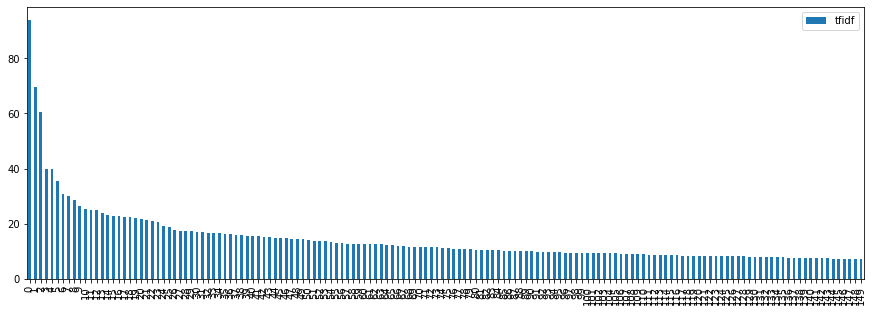

In [ ]:
tfidf_list.head(150).plot.bar(figsize=(15,5))

In [ ]:
def proj_colecao(word2vec, tfidf_list, total=400):
    
    labels = []
    tokens = []

    for index,row in tfidf_list.iterrows():
      try:
        tokens.append(word2vec[row['word']])
        labels.append(row['word'])
        if len(labels) >= total: break
      except:
        1
    
    tsne_model = TSNE(perplexity=30, n_components=2, init='random')
    new_values = tsne_model.fit_transform(tokens)
    
    kmeans = KMeans(n_clusters=5,n_init=10,init='random',max_iter=300)
    kmeans.fit(new_values)

    my_colors = {0: 'aqua', 1:'magenta',2:'orangered',3:'yellow', 4: 'purple'}

    x = []
    y = []
    
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(27, 18)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], color = my_colors.get(kmeans.labels_[i], 'gray'))
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

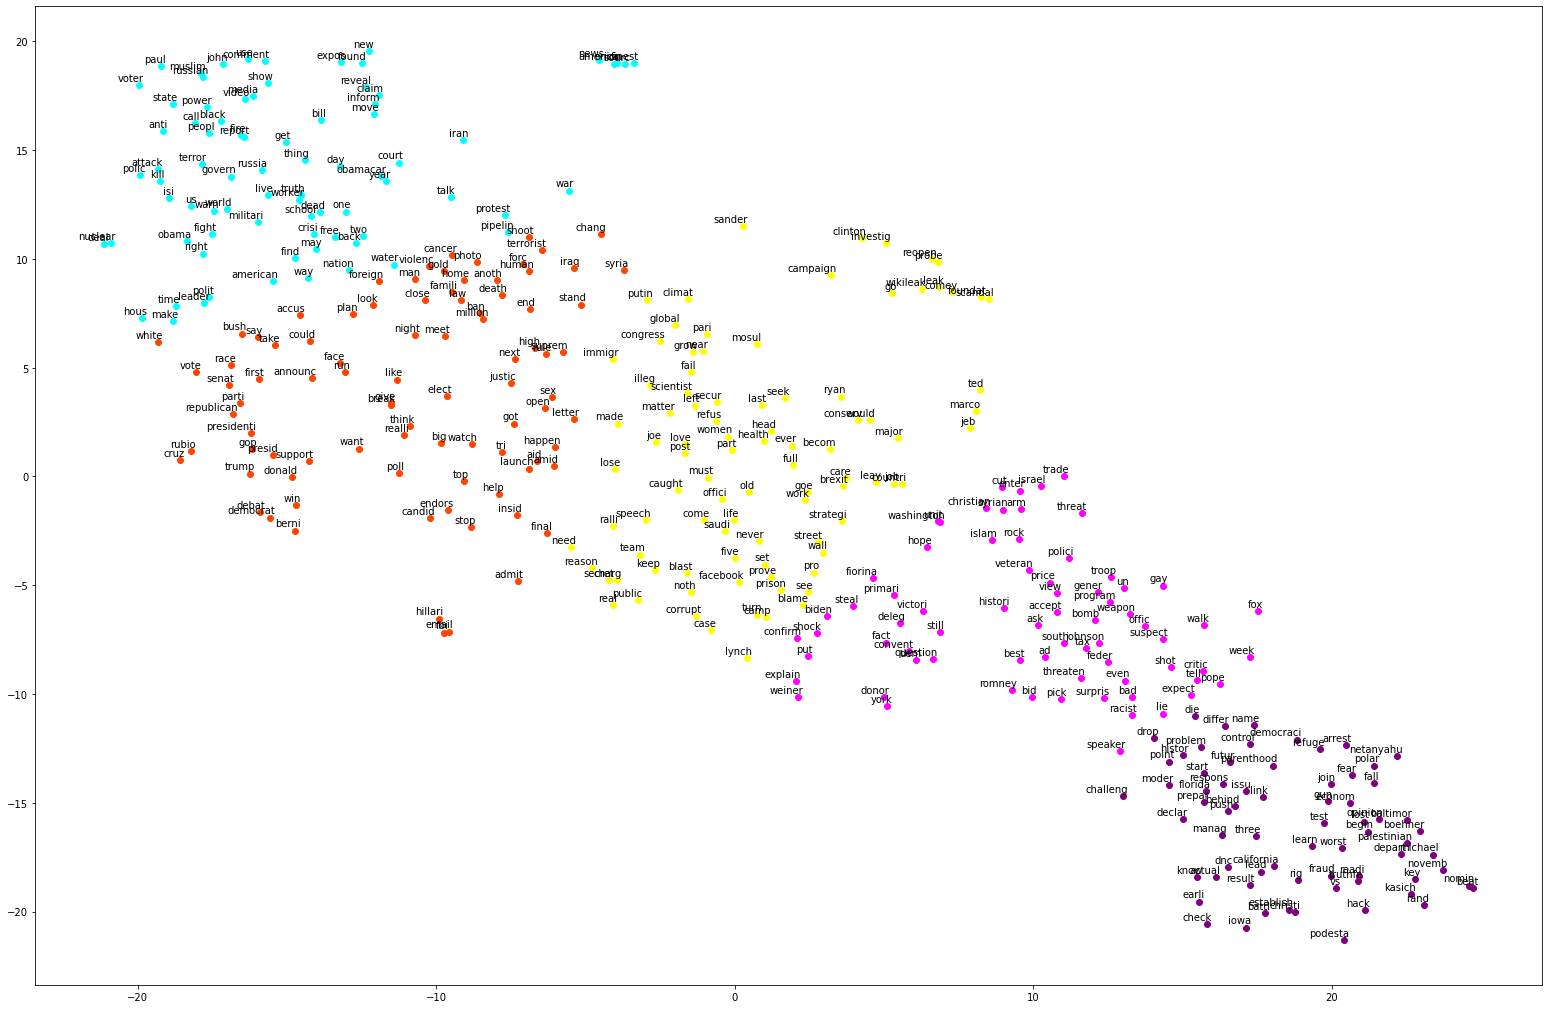

In [ ]:
proj_colecao(model.wv,tfidf_list)

### Visualização baseada na k-NNG

Aqui iremos utilizar o método Bag of Words -- mais especificamente a ponderação TF-IDF realizada no vetor de BoW, já que pesos baseados somente na freqiência podem não representar adequadamente o problema. Ao utilizar o TF-IDF, levamos em conta que atributos que ocorrem em muitos objetos não são relevantes e atributos que são frequentes em um objeto são relevantes. Como medida de proximidade entre palavras, optou-se por utilizar a similaridade cosseno, já que outras medidas -- como a distância euclidiana -- não representam muito bem conceito de proximidade entre textos. Por fim, como a base possuía informação de classe -- FAKE ou REAL -- utilizamos ela para colorir o grafo.

In [ ]:
X = vsm

A = kneighbors_graph(X, n_neighbors=3, metric="cosine")

A.toarray()

A.shape

(3000, 3000)

In [ ]:
G = nx.Graph(A)

In [ ]:
# determinando a posição dos vértices com algoritmo de layout baseado em força
pos = nx.spring_layout(G)
for node in G.nodes():
  G.nodes[node]['pos'] = pos[node]

for index,row in df.iterrows():
  G.nodes[index]['text'] = str(row['title'])


edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text')

In [ ]:
color_code = {}
colors = []
for v in list(df['label']):
  if v not in color_code: color_code[v] = len(color_code)
  colors.append(color_code[v])

color_code

{'FAKE': 0, 'REAL': 1}

In [ ]:
# adicionando texto e cor nos nodes
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(G.nodes[node]['text'])

node_trace.marker.color = colors
node_trace.text = node_text

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Grafo de notícias fakes e reais',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()

### Projeção Bidimensional de palavras

Agora, iremos fazer algumas projeções bidimensionais de palavras -- e suas vizinhas -- por meio de word vectors. Também, realizamos projeções envolvendo duas e três palavras -- e suas respectivas vizinhas.

In [ ]:
def tsne_plot(word2vec, palavras, num_vizinhos=10):
    labels = []
    tokens = []
    color = []

    i=0

    for word in palavras:
      palavras_vizinhas = word2vec.wv.most_similar(word,topn=num_vizinhos)
      
      tokens.append(word2vec.wv.__getitem__(word))
      labels.append(word)
      color.append(i)
      i += 1
      
      for item in palavras_vizinhas:
        tokens.append(word2vec.wv.__getitem__(item[0]))
        labels.append(item[0])
        color.append(i)
      i += 1
    
    tsne_model = TSNE(perplexity=30, n_components=2)
    new_values = tsne_model.fit_transform(tokens)

    kmeans = KMeans(n_clusters=len(palavras),n_init=10,init='random',max_iter=300)
    kmeans.fit(new_values)

    my_colors = {0: 'darkcyan', 1:'cyan',2:'darkmagenta',3:'magenta', 
                 4: 'darkblue', 5: 'blue', 6: 'darkgreen', 7: 'green'}

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 6)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], color = my_colors.get(color[i], 'gray'))
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

De acordo com a ponderação TF-IDF realizada anteriormente, as palavras mais relevantes em nosso conjunto de dados são palavras como: Trump, Hillary, Clinton, war, war, fbi, entre outras. Tomando isto como base, iremos visualizar algumas palavras e suas vizinhas.

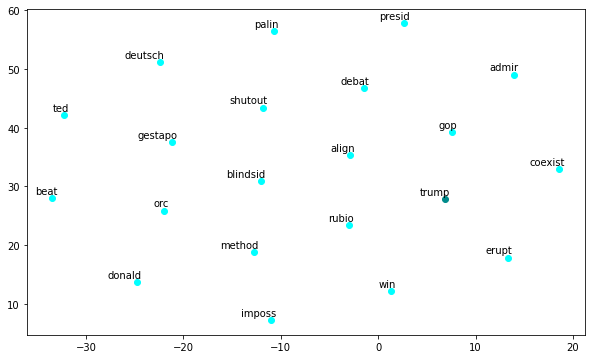

In [ ]:
tsne_plot(model, ['trump'], num_vizinhos=20)

Nesta projeção, observamos que Trump está muito relacionado com palavras como president, democrat, win, latino.

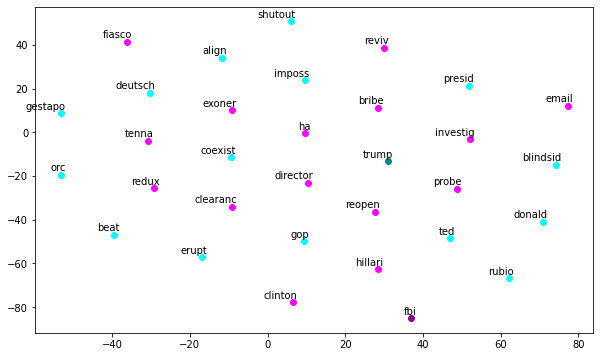

In [ ]:
tsne_plot(model, ['trump', 'fbi'], num_vizinhos=15)

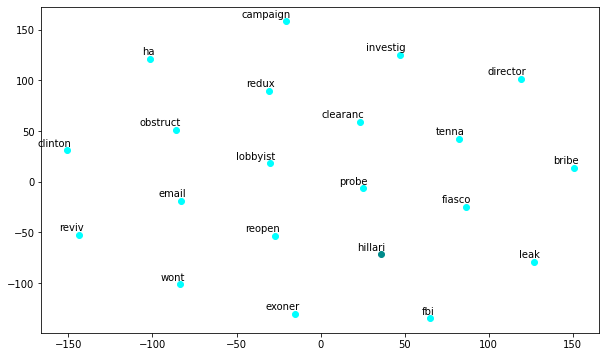

In [ ]:
tsne_plot(model, ['hillari'], num_vizinhos=20)

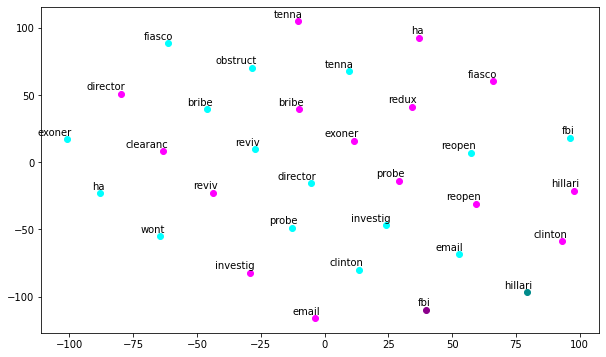

In [ ]:
tsne_plot(model, ['hillari', 'fbi'], num_vizinhos=15)

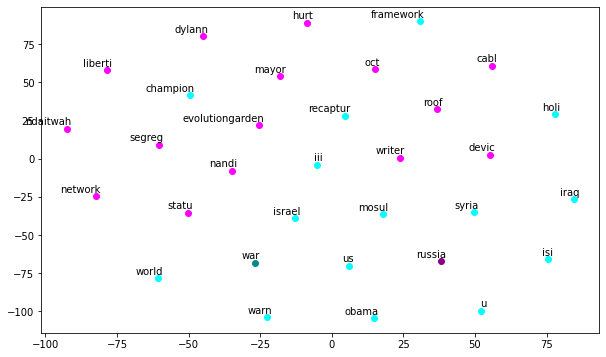

In [ ]:
tsne_plot(model, ['war', 'russia'], num_vizinhos=15)

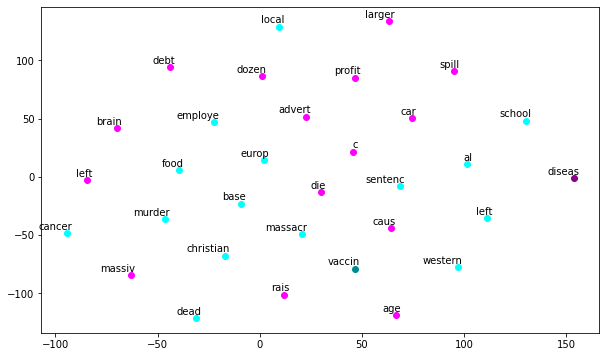

In [ ]:
tsne_plot(model, ['vaccin', 'diseas'], num_vizinhos=15)

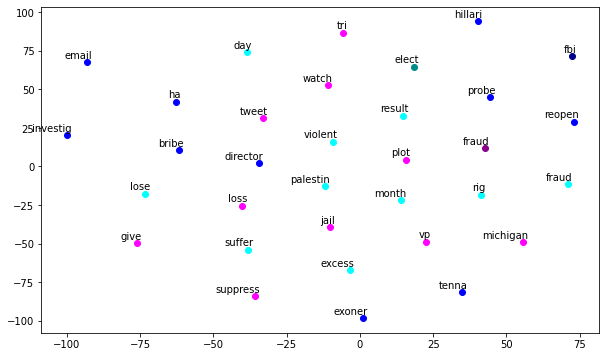

In [ ]:
tsne_plot(model, ['elect', 'fraud', 'fbi'], num_vizinhos=10)

### Visualização baseada em tópicos

In [ ]:
topic_model = BERTopic(language="multilingual", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(d)

Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

2021-12-14 16:48:19,629 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.

2021-12-14 16:48:44,525 - BERTopic - Reduced dimensionality with UMAP
2021-12-14 16:48:45,282 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
# tópicos gerados
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1168,-1_trump_clinton_hillari_elect
1,0,159,0_go_sander_berni_googl
2,1,116,1_obama_trade_bush_obamacar
3,2,107,2_trump_donald_campaign_gop
4,3,95,3_russia_russian_putin_war
5,4,66,4_democrat_senat_republican_parti
6,5,53,5_iran_nuclear_deal_kerri
7,6,52,6_email_clinton_leak_scandal
8,7,49,7_american_congress_america_elect
9,8,48,8_media_fox_news_polit


In [ ]:
topic_model.visualize_barchart(top_n_topics=9)

Entre os top-9 tópicos, os que consideramos mais relevantes:
- **Tópico 1**: este tópico, que relaciona palavras como "obama", "obamacar" e "plan" trata sobre o plano Obamacare, uma lei federal dos Estados Unidos sancionada pelo presidente Barack Obama, de atendimento médico financeiramente acessível à população.
- **Tópico 4**: este tópico relaciona palavras como "russia", "ukrain", "vladimir" e "syria". Como as notícias do dataset são americanas, provavelmente este tópico trata mais de conflitos políticos com esses países.
- **Tópico 5**: com termos como "leak" e "scandal", este tópico fala, provavelmente, sobre revelações da vigilância global, dadas por Snowden.
- **Tópico 6**: este tópico aborda questões de gênero e sexualidade. É possível observar uma relação das notícias com o casamento LGBT, que foi aprovado nos EUA em 2015.

In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=30)

In [ ]:
topic_model.visualize_topics()